In [10]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
data = pd.read_csv('../datasets/one_hot_encoded/combined-data.csv').groupby("Year", as_index=False).mean()

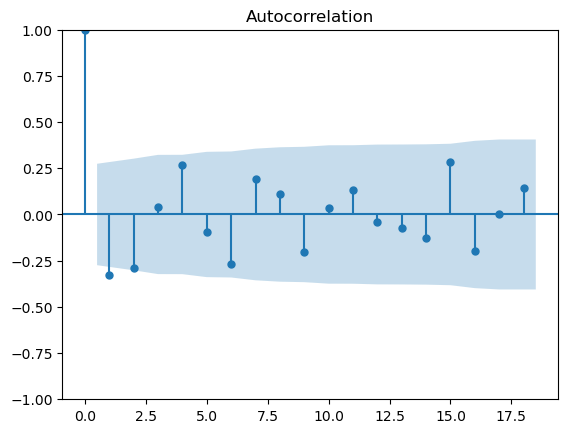

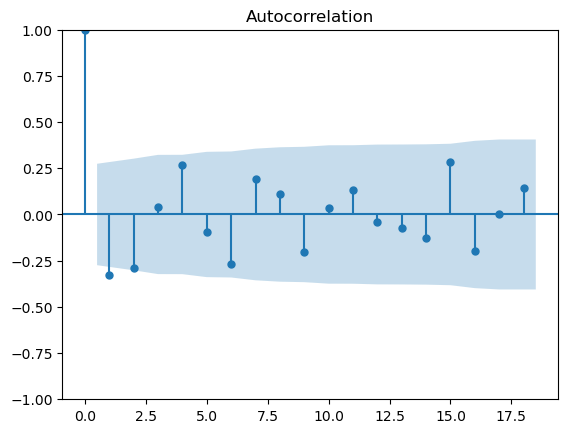

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data.Temperature.diff().describe()
plot_acf(data.Temperature.diff().dropna())

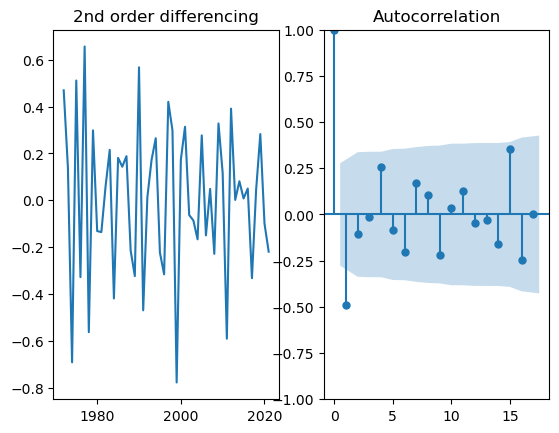

In [33]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(data.Temperature.diff().diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(data.Temperature.diff().diff().dropna(), ax=ax2)
plt.show()

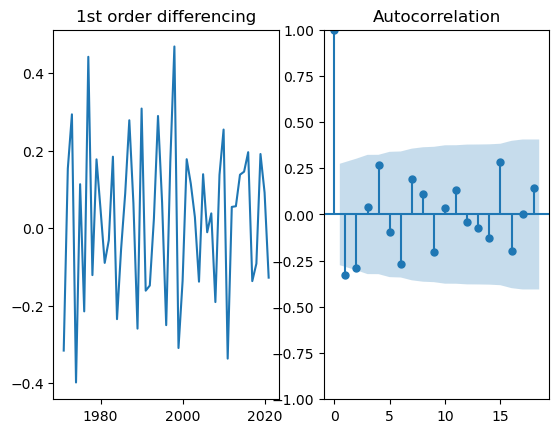

In [34]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(data.Temperature.diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(data.Temperature.diff().dropna(), ax=ax2)
plt.show()

In [35]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data.Temperature)
print("p-value: ", result[1])

result = adfuller(data.Temperature.diff().dropna())
print("1st diff p-value: ", result[1])

result = adfuller(data.Temperature.diff().diff().dropna())
print("2nd diff p-value: ", result[1])

p-value:  0.978613659739638
1st diff p-value:  1.4756444943196453e-11
2nd diff p-value:  8.988537979788989e-05


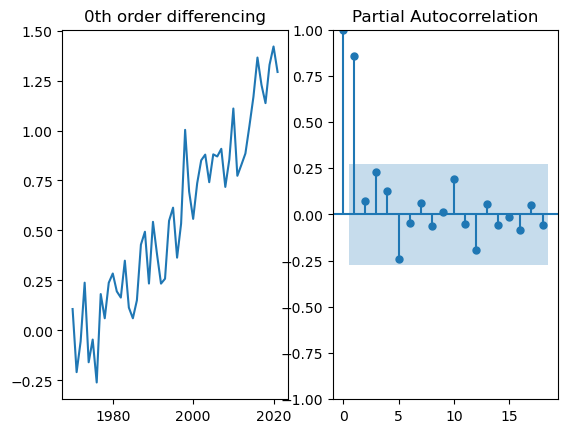

In [36]:
# 1st difference is beyond the 0.05 test threshold, so that is our d value
# d = 1

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('0th order differencing')
ax1.plot(data.Temperature)

ax2 = f.add_subplot(122)
plot_pacf(data.Temperature, ax=ax2)
plt.show()

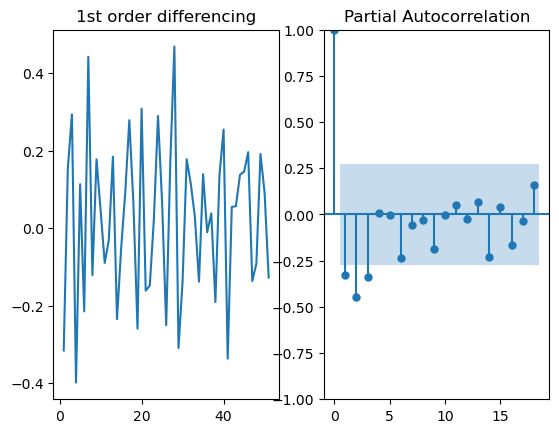

In [89]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(data.Temperature.diff().dropna())

ax2 = f.add_subplot(122)
plot_pacf(data.Temperature.diff().dropna(), ax=ax2)
plt.show()

In [ ]:
# 1st bar is most significant in both autocorrelations, so we set p = 1


# We use the formula ARIMA(p = 1, d=1, q=2)

In [173]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(data.Temperature, order=(1, 1, 2))
model = arima_model.fit()
# print(model.summary())

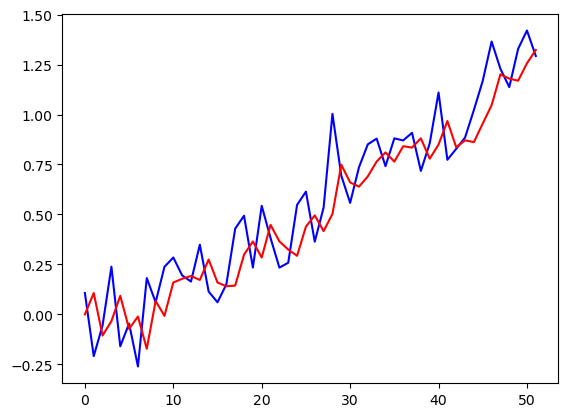

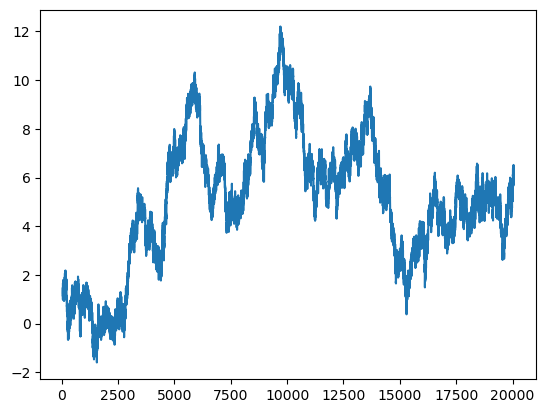

In [208]:
plt.plot(data.Year-1970, data.Temperature, color="blue")
plt.plot(model.predict(), color="red")
plt.show()

plt.plot(model.simulate(20000, anchor=49))

plt.show()

In [275]:
data = pd.read_csv('../datasets/one_hot_encoded/combined-data.csv')
cc = [c for c in data.columns if c.startswith("Country_")]
import math 
maxdg = -math.inf
mindg = +math.inf
maxdc = None 
mindc = None 

for c in cc:
    q = f"`{c}` == 1"
    entries = data.query(q)

    diffs = entries

    maxd = max(diffs.Co2)
    mind = min(diffs.Co2)
    if maxd > maxdg:
        maxdg = maxd 
        maxdc = c
    if mind < mindg:
        mindg = mind 
        mindc = c

print(maxdc, mindc)
print(maxdg, mindg)
    

Country_United States Country_Anguilla
6004.362376 0.002108963


              Year  Temperature          Co2  Country_Albania  \
count    52.000000    52.000000    52.000000             52.0   
mean   1995.500000     0.574615  5203.567084              0.0   
std      15.154757     0.576789   442.739215              0.0   
min    1970.000000    -0.415000  4464.105812              0.0   
25%    1982.750000     0.069500  4865.186817              0.0   
50%    1995.500000     0.538500  5112.728086              0.0   
75%    2008.250000     0.992500  5524.338573              0.0   
max    2021.000000     2.224000  6004.362376              0.0   

       Country_Algeria  Country_Angola  Country_Anguilla  \
count             52.0            52.0              52.0   
mean               0.0             0.0               0.0   
std                0.0             0.0               0.0   
min                0.0             0.0               0.0   
25%                0.0             0.0               0.0   
50%                0.0             0.0               0

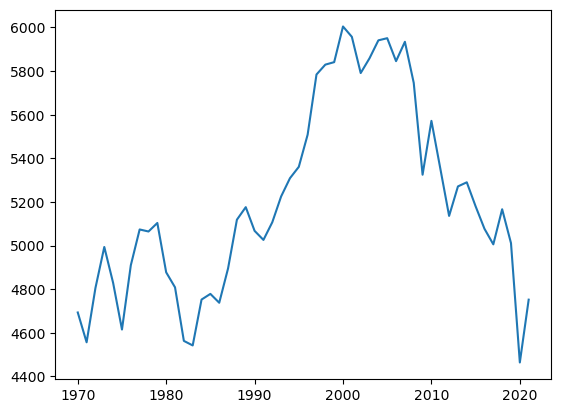

In [287]:
data = pd.read_csv('../datasets/one_hot_encoded/combined-data.csv').query("`Country_United States` == 1").dropna()

plt.plot(data.Year[1:], data.Co2)